In [31]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d, linregress
from numba import njit

In [2]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [3]:
@njit
def rodrigues_formula(k, v, theta):
    N = v.shape[0]
    v_rot = np.zeros(np.shape(v))
    
    ctheta = np.cos(theta)
    stheta = np.sin(theta)
    
    for i in range(N):
        v_rot[i] = v[i] * ctheta + np.cross(k, v[i]) * stheta + k * (np.dot(k, v[i])) * (1-ctheta)
    
    return v_rot

In [4]:
name = 'MW3_MHG0.25_GSE2_MHG0.18-lvl4'
COM_fpath = basepath + 'anlys/COM/COM_' + name + '.npy'
COM_file = np.load(COM_fpath, allow_pickle=True).item()

In [28]:
sn = {}
sn_Rcut10 = {}
sn_iso = {}
num_list = [0, 200, 400, 600, 800]
for num in num_list:
    try:
        sn[num] = arepo.Snapshot(basepath + 'runs/MW3_MHG0.25_GSE2_MHG0.18/lvl4/output', 
                             num, combineFiles=True)
        sn_Rcut10[num] = arepo.Snapshot(basepath + 'runs/MW3_MHG0.25_GSE2_MHG0.18_Rcut10/lvl4/output', 
                             num, combineFiles=True)
    except:
        pass
    
    try:
        sn_iso[num] = arepo.Snapshot(basepath + 'runs/MW3iso_fg0.7_MHG0.25_RC9/lvl4/output', num,
                    combineFiles=True)
    except:
        pass

In [6]:
def get_rotated_gas_pos(sn, COM_file, idx):
    pos = sn.part0.pos.value - COM_file['MW_COM'][idx]
    vel = sn.part0.vel.value - COM_file['MW_COMV'][idx]
    
    ang_mom = COM_file['MW_AngMom'][idx]

    angmom_dir = ang_mom/np.linalg.norm(ang_mom)
    theta = np.arccos(np.dot(angmom_dir, np.array([0, 0, 1])))
    
    k = np.cross(ang_mom, np.array([0, 0, 1.]))
    k /= np.linalg.norm(k)

    pos_rot = rodrigues_formula(k, pos, theta)
    vel_rot = rodrigues_formula(k, vel.astype(np.float64), theta)

    return pos_rot, vel_rot

In [25]:
def get_surfdens_profile(R, mass):
    Rmin = 0
    dR = 0.5
    
    ave_R = []
    surfdens = []
    
    while Rmin < 30:
        key = np.logical_and(R > Rmin, R < Rmin+dR)
        
        ave_R.append(np.mean(R[key]))
        
        mass_in_bin = np.sum(mass[key])
        area = np.pi * ((Rmin+dR)**2 - Rmin**2)
        surfdens.append(mass_in_bin/area)
        
        Rmin += dR
    
    return np.array(ave_R), np.array(surfdens)

In [52]:
pos_rot = {}
vel_rot = {}
R = {}
mass = {}

aveR = {}
surfdens = {}
for num in num_list:
    pos_rot[num], vel_rot[num] = get_rotated_gas_pos(sn_iso[num], COM_file, num)
    R[num] = np.linalg.norm(pos_rot[num][:,:2], axis=1)
    key = np.abs(pos_rot[num][:,2]) < 3
    mass[num] = sn_Rcut10[num].part0.mass.value
    
    aveR[num], surfdens[num] = get_surfdens_profile(R[num][key], mass[num][key])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 829461 but corresponding boolean dimension is 608919

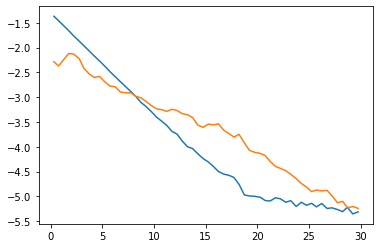

In [44]:
plt.plot(aveR[0], np.log10(surfdens[0]))
plt.plot(aveR[800], np.log10(surfdens[800]))


In [50]:
key = aveR[0] < 10
ans = linregress(aveR[0][key], np.log(surfdens[0][key]))
print(-1/ans.slope)

2.122103459979437


In [51]:
key = aveR[0] < 20
ans = linregress(aveR[800][key], np.log(surfdens[800][key]))
print(-1/ans.slope)

4.617968431757593


In [39]:
ans.intercept

-1.3220691005910854

In [40]:
ans

LinregressResult(slope=-0.1943237610084834, intercept=-1.3220691005910854, rvalue=-0.9995449332164493, pvalue=7.934319322175968e-29, stderr=0.0013822623693424377, intercept_stderr=0.00797213644296919)

In [18]:
np.log10(surfdens[0])

array([[-3.73465419, -3.76281745, -3.72501751, ..., -4.45909742,
        -4.46685309, -4.45534236],
       [-3.34644957, -3.37461283, -3.33681288, ..., -4.07089279,
        -4.07864846, -4.06713774],
       [-3.22367084, -3.2518341 , -3.21403415, ..., -3.94811406,
        -3.95586973, -3.94435901],
       ...,
       [-3.85026162, -3.87842488, -3.84062494, ..., -4.57470485,
        -4.58246052, -4.57094979],
       [-3.89259861, -3.92076186, -3.88296192, ..., -4.61704183,
        -4.6247975 , -4.61328677],
       [-3.95036935, -3.97853261, -3.94073266, ..., -4.67481258,
        -4.68256825, -4.67105752]])